In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp /content/gdrive/My\ Drive/podaci.tar /content/

In [0]:
cd /content/

In [0]:
mkdir data

In [0]:
cp /content/podaci.tar /content/data/

In [0]:
cd /content/data/

In [0]:
!tar -xvf podaci.tar

In [0]:
#U ovoj celiji se nalaze biblioteke koje smo koristili, kao i definicije svih funkcija
import os
from os.path import join
import json
import random
import itertools
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import (Input, Dense, Activation, 
                        Reshape, Lambda)
from keras.layers.recurrent import GRU
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.optimizers import (SGD, RMSprop, Nadam)
from keras.preprocessing import image
import cv2
from collections import Counter
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Funkcija koja pomaze da uvidimo koji se sve karakteri nalaze u skupu, 
# kao i da li su u sva tri podskupa isti karakteri
def character_validation(path, tag):
    ann_path = join(path, 'ann')
    all_characters = ''
    for filename in os.listdir(ann_path):
        json_path = join(ann_path, filename)
        ann = json.load(open(json_path, 'r'))
        description = ann['description']
        all_characters += description
    return Counter(all_characters)

# Funkcija koja mapira string u listu karaktera
def text_to_labels(text):
    return list(map(lambda x: all_characters.index(x), text))

# Klasa koja se bavi preprocesiranjem slika koje se salju neuronskoj mrezi
class TextImageGenerator:
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = 8
        self.samples = []
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        
        
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                ann = json.load(open(json_filepath, 'r'))
                description = ann['description']
                self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
    

        
    def prepare_image(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_path, text) in enumerate(self.samples):
            img = cv2.imread(img_path, 0)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            rows = len(img)
            cols = len(img[0])
            outputImg = img
            minGray = np.amin(img)
            maxGray = np.amax(img)
            diff = maxGray-minGray

            for j in range(0,rows):
              for k in range(0,cols):
                #fazifikacija
                memFunc = (img[j][k] - minGray)/diff
                #modifikacija member funkcije od strane INT operatora
                if(memFunc <= 0.5 and memFunc > 0.5):
                  memFunc = 2 * (memFunc**2)
                elif(memFunc <= 1 and memFunc > 0.5):
                  memFunc = 1 - 2*((1-memFunc)**2)

                #defazifikacija
                outputImg[j][k] = minGray + memFunc*diff
                
            self.imgs[i, :, :] = outputImg/255
            self.texts.append(text)
        
    def get_output_size(self):
        return len(all_characters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_image_group(self):
        while True:            
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
                        
            yield (inputs, outputs)

# Funkcije zaduzene za trening podataka
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Funkcija kojoj se prosledjuje sirina slike, broj epoha, 
# broj sa kojim zelimo da podelimo ~10000 slika koje saljemo svakoj od epoha, i vrsta optimizacije
def train(img_w, number_of_epochs, divide_sample_rate, optimization):
    
    img_h = 64

    
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    batch_size = 32
    
    input_shape = (img_w, img_h, 1)
        
    downsample_factor = pool_size ** 2
    
    train_data = TextImageGenerator('/content/data/train', 'train', img_w, img_h, batch_size, downsample_factor)
    train_data.prepare_image()
    val_data = TextImageGenerator('/content/data/train', 'val', img_w, img_h, batch_size, downsample_factor)
    val_data.prepare_image()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)


    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    
    inner = Dense(train_data.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[train_data.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    
    opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    if optimization == "rms":
      opt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    elif optimization == "nadam":
      opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt, metrics = ['accuracy'])
    
    test_func = K.function([input_data], [y_pred])

    history = model.fit_generator(generator=train_data.next_image_group(), 
                        steps_per_epoch=train_data.n/divide_sample_rate,
                        epochs=number_of_epochs, 
                        validation_data=val_data.next_image_group(), 
                        validation_steps=val_data.n)

    return (history, model)

# Funkcija koja dekodira izlaz iz mreze
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(all_characters):
                outstr += all_characters[c]
        ret.append(outstr)
    return ret

# Funkcija koja graficki pokazuje napredak treninga u odnosu epoha-gubici
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# Funkcija koja graficki pokazuje napredak treninga u odnosu epoha-preciznost
def plot_acc(model):
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# Funkcija koja uzima izlaz iz neuronske mreze, dekodira ga,
# i zatim prediktuje karaktere za tablice iz nasumicno odabrane grupe tablica
def test_function(model):
    test_data = TextImageGenerator('/content/data/test', 'test', 128, 64, 8, 4)
    test_data.prepare_image()

    net_inp = model.get_layer(name='the_input').input
    net_out = model.get_layer(name='softmax').output

    for inp_value, _ in test_data.next_image_group():
        n = inp_value['the_input'].shape[0]
        X_data = inp_value['the_input']
        net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
        pred_texts = decode_batch(net_out_value)
        labels = inp_value['the_labels']

        for i in range(n):
            print('Predicted characters: %s\n' % (pred_texts[i],))
            img = X_data[i][:, :, 0].T
            imgplot = plt.imshow(img, cmap='gray')
            plt.show()
            print("************************************************************************")
        break

In [0]:
sess = tf.Session()
K.set_session(sess)
train_characters = character_validation('/content/data/train', 'train')
val_characters = character_validation('/content/data/train', 'val')
test_characters = character_validation('/content/data/test', 'test')

train_unique = set(train_characters.keys())
val_unique = set(val_characters.keys())
test_unique = set(test_characters.keys())

if train_unique == val_unique and val_unique == test_unique:
    print('Characters in train, val and test images do match!\n')
else:
    print("Characters in train, val and test images don't match!\n")
    
all_characters = sorted(list(train_unique))

print('All characters that appear in plates:', ' '.join(all_characters))
print("\nInformations that we feed into NN:\n")
print("1. Input image of vechicle registration")
number = [x for x in range(22)]
zipped = zip(number, all_characters)
encoded = ""
for e1, e2 in zipped:
  encoded += (str(e1))
  encoded += ' '
print("2. Characters from above (encoded respectively): %s" % encoded)
print("3. Input length is (image width / 4 - downsample_factor) => 128 / 4 - 2 = 30.")
print("4. Plate length which is 8.")

Characters in train, val and test images do match!

All characters that appear in plates: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y

Informations that we feed into NN:

1. Input image of vechicle registration
2. Characters from above (encoded respectively): 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
3. Input length is (image width / 4 - downsample_factor) => 128 / 4 - 2 = 30.
4. Plate length which is 8.


In [0]:
model = train(128, 15, 100, "sgd")

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
_____________________________________

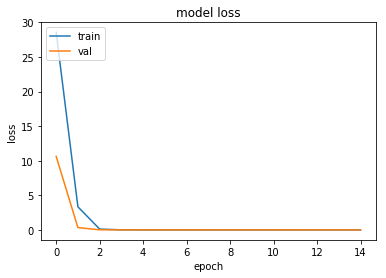

In [0]:
plot_history(model[0])

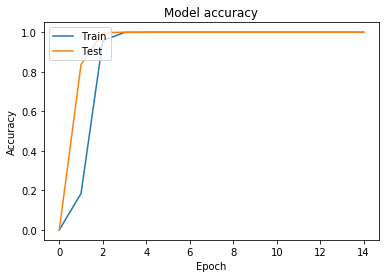

In [0]:
plot_acc(model[0])

In [0]:
test_function(model[1])

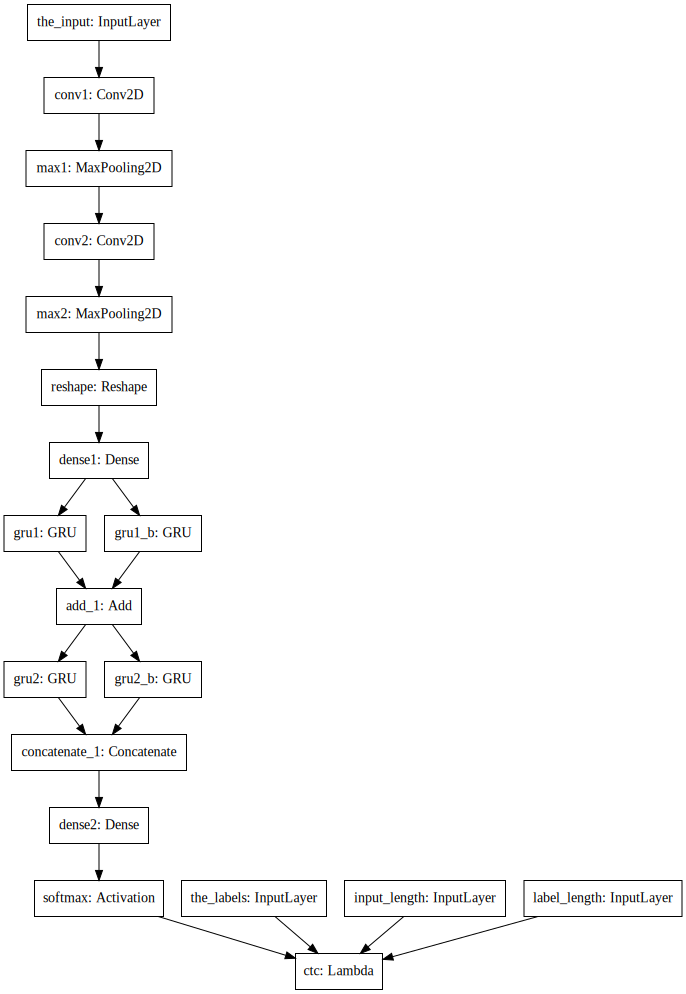

In [0]:
SVG(model_to_dot(model[1]).create(prog='dot', format='svg'))

In [0]:
model1 = train(128, 2, 1, "sgd")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
test_function(model1[1])

In [0]:
model2 = train(128, 2, 1, "rms")

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
_____________________________________

In [0]:
test_function(model2[1])

In [0]:
model3 = train(128, 2, 1, "nadam")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
test_function(model3[1])

In [0]:
model4 = train(128, 1, 1, "sgd")

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
_____________________________________

Predicted characters: M383HY43



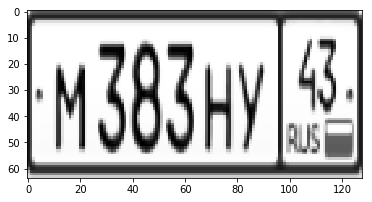

************************************************************************
Predicted characters: O474EK89



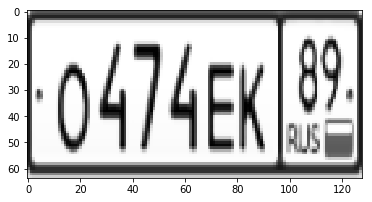

************************************************************************
Predicted characters: P348PC67



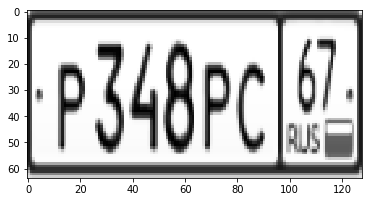

************************************************************************
Predicted characters: K223OK78



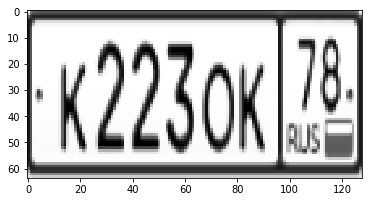

************************************************************************
Predicted characters: X053PM55



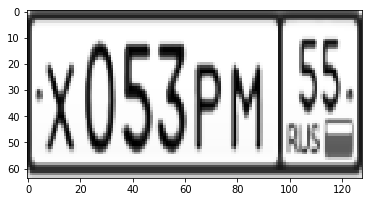

************************************************************************
Predicted characters: C181CM60



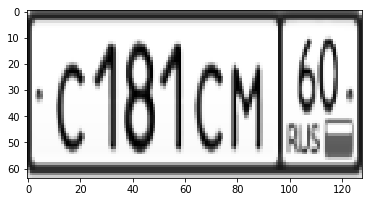

************************************************************************
Predicted characters: M607ET16



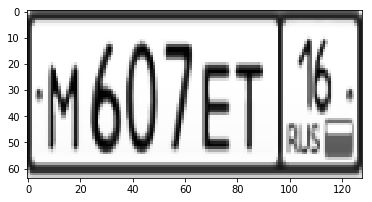

************************************************************************
Predicted characters: K535MC23



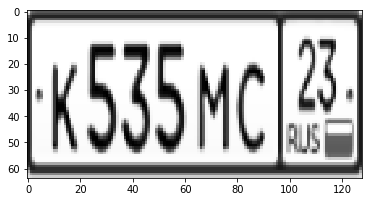

************************************************************************


In [0]:
test_function(model4[1])